In [1]:
%pylab inline
%run /nfs/research2/teichmann/valentine/scrnatb/scrnatb/toolbox

sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.set_context('poster', font_scale=1.5)

Populating the interactive namespace from numpy and matplotlib


In [86]:
stats = pd.read_csv('public_stats.csv', index_col=0)

In [171]:
concentration = pd.read_table('ERCC_Controls_Analysis.txt', index_col=1)['concentration in Mix 1 (attomoles/ul)']
concentration = concentration.sort_index()

In [173]:
from sklearn.linear_model import LogisticRegression

In [337]:
lr = LogisticRegression(solver='liblinear', fit_intercept=True)

In [338]:
s = stats.sample()

In [339]:
s

,ERCC-00002,ERCC-00003,ERCC-00004,ERCC-00009,ERCC-00012,ERCC-00013,ERCC-00014,ERCC-00016,ERCC-00017,ERCC-00019,...,ERCC-00162,ERCC-00163,ERCC-00164,ERCC-00165,ERCC-00168,ERCC-00170,ERCC-00171,total_expression,detected_genes,reads
SRP035326_batch_32_CCAAGT,15.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,54.0,796.0,29525.0


In [379]:
s = stats.loc[['SRP045452_1772058148_D02']]

In [380]:
X = np.log(concentration[:, None])

In [381]:
y = s.iloc[0].ix[concentration.index] >= 0.1
if y.sum() < 8:
    print('Not enough spikes, take another sample')

In [382]:
lr.fit(X, y)
midpoint = -lr.intercept_ / lr.coef_[0]

In [383]:
xx = np.linspace(np.log(concentration.min()), np.log(concentration.max()))[:, None]

In [384]:
yy = lr.predict_proba(xx)[:, 1]

In [385]:
sns.set_style('ticks')
sns.set_context('poster', font_scale=1)

In [386]:
from matplotlib.colors import ListedColormap

In [387]:
lcm = ListedColormap(sns.color_palette("RdBu", n_colors=2))

In [388]:
midpoint

array([ 2.8878078])

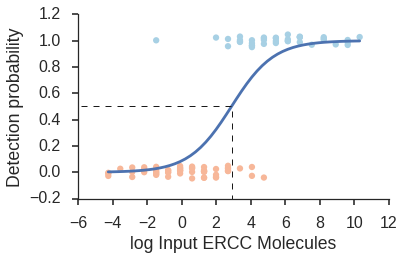

In [390]:
figsize(6, 4)
plt.scatter(X, y - 0.05 + np.random.rand(*y.shape) * 0.1, edgecolor='none', s=40, c=y, cmap=lcm);
plt.plot(xx, yy);
plt.autoscale(False)
plt.plot([midpoint, midpoint], [-1, 0.5], c='k', linestyle='--', lw=1.);
plt.plot([-10, midpoint], [0.5, 0.5], c='k', linestyle='--', lw=1.);
sns.despine()
sns.axlabel('log Input ERCC Molecules', 'Detection probability')
plt.tight_layout()
plt.savefig('figures_rev_1/detection-illustration.pdf')

In [391]:
y = np.log(s.iloc[0].ix[concentration.index]) \
                    .replace([np.inf, -np.inf], np.nan) \
                    .dropna()

In [392]:
X = np.log(concentration[y.index])

In [393]:
from scipy import stats as sstats

In [394]:
reg_res = sstats.linregress(X, y)

In [395]:
reg_res

LinregressResult(slope=0.76170891895151938, intercept=-1.8451492207538958, rvalue=0.91054953338351174, pvalue=2.2308977371403919e-15, stderr=0.05763743831026398)

In [396]:
xx = np.linspace(X.min(), X.max())

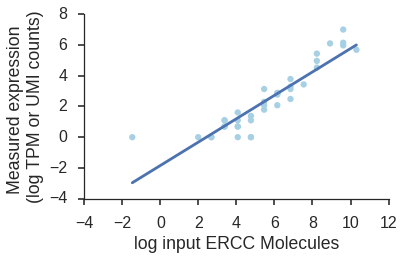

In [399]:
plt.scatter(np.log(concentration[y.index]), y, edgecolor='none', s=40, cmap=lcm, c=np.ones_like(y), vmin=0);
plt.plot(xx, reg_res.slope * xx + reg_res.intercept);
sns.despine()
sns.axlabel('log input ERCC Molecules', 'Measured expression \n(log TPM or UMI counts)')
plt.tight_layout()
plt.savefig('figures_rev_1/correlation-illustration.pdf')

In [363]:
# UMI efficiency illustration

In [364]:
conditions = pd.read_csv('public_conditions.csv', index_col=0)

In [365]:
cell = conditions.query('protocol == "STRT-Seq"').sample().iloc[0].name

In [366]:
cell

'SRP045452_1772062113_G08'

In [367]:
cell = 'SRP045452_1772066076_H07'

In [368]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [369]:
input_molecules = \
conditions['volume'][cell] * 1e-3 * \
1. / (conditions['dilution'][cell]) * 1e-18 * \
6.02214179 * 1e23 * \
concentration

In [370]:
s = stats.loc[cell][input_molecules.index]

In [371]:
df = pd.DataFrame({'input': input_molecules, 'expression': s})

In [372]:
mod = smf.ols(formula='np.log10(expression / input) ~ 1', data=df.replace(0, np.nan).dropna())

In [373]:
input_molecules.min()

0.0038766357433334163

In [374]:
res = mod.fit()

In [375]:
res.params['Intercept']

-0.72358369234879849

In [376]:
10 ** res.params['Intercept']

0.1889802014701214

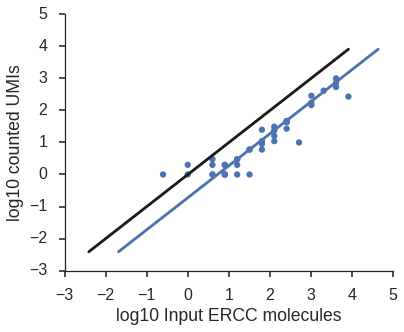

In [377]:
figsize(6, 5)
y = log10(s)
X = log10(input_molecules)
xx = np.linspace(X.min(), X.max())

plt.scatter(X, y, s=40, edgecolor='none', c='b')
plt.plot(xx, xx, c='k', label='#UMI = #Molecules')
plt.plot(xx - res.params['Intercept'], xx, label='#UMI = Efficiency * #Molecules')
sns.despine()
sns.axlabel('log10 Input ERCC molecules', 'log10 counted UMIs')
plt.tight_layout()
plt.savefig('figures_rev_1/supp-umi-efficiency-illustration.pdf')